#### Loading Datasets

In [ ]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import os



In [ ]:
samples_dir = os.path.abspath("../../../Task_1/samples")
labels_dir = os.path.abspath("../../../Task_1/labels")

In [ ]:
class SatDataset(Dataset):
    def __init__(self, img_dir, file_names, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        fname = self.file_names[idx]
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        ndvi_fname = fname.replace("_img_", "_ndvi_")
        ndvi_path = os.path.join(self.label_dir, ndvi_fname)
        if not os.path.exists(ndvi_path):
            raise FileNotFoundError(f"Label not found for {fname} at {ndvi_path}")
        ndvi_img = Image.open(ndvi_path)

        ndvi_arr = np.array(ndvi_img).astype(np.float32)
        ndvi_norm = (ndvi_arr - ndvi_arr.min()) / (ndvi_arr.max() - ndvi_arr.min())
        ndvi_norm = ndvi_norm * 2 - 1

        ndvi_mean = ndvi_norm.mean()
        label = 1 if ndvi_mean > 0.1 else 0
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
from torchvision import transforms

width = 256
height = 256

train_transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])


In [ ]:
file_names = (os.listdir(samples_dir))
label_names = (os.listdir(labels_dir))

print("num images:", len(file_names))
print("num labels:", len(label_names))

num images: 614
num labels: 614


In [ ]:
missing_labels = [f for f in file_names if f not in label_names]
print("images without matching label:", len(missing_labels))
print(missing_labels[:10])

images without matching label: 614
['S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_0.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_1.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_10.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_100.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_101.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_102.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_103.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_104.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_105.tiff', 'S2A_MSIL2A_20171025T150721_N0500_R082_T19QGA_20230910T203157.SAFE_img_106.tiff']


In [ ]:
dataset = SatDataset(
    img_dir=samples_dir,
    file_names=file_names,
    label_dir = labels_dir,
    transform=transform
)

len(dataset)

614

In [ ]:
from collections import Counter

full_labels = []

for i in range(len(dataset)):
    _, y = dataset[i]
    full_labels.append(int(y))

print("Full dataset label counts:", Counter(full_labels))


Full dataset label counts: Counter({1: 462, 0: 152})


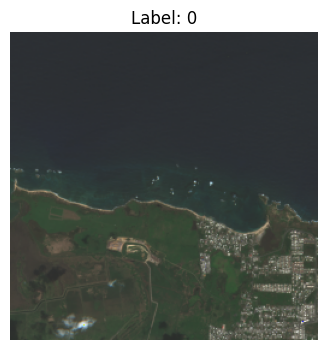

In [ ]:
import matplotlib.pyplot as plt
import torch

MEAN = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
STD  = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)

def show_sample(dataset, idx):
    img, label = dataset[idx]
    
    # denormalize
    img_vis = img.clamp(0,1)
    img_vis = img_vis.permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(4,4))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(f"Label: {label.item()}")
    plt.show()


show_sample(dataset, 2)

In [ ]:
from torch.utils.data import random_split

n = len(dataset)
n_train = int(0.7 * n)
n_test = n - n_train 

train_ds, test_ds = random_split(
    dataset,
    [n_train, n_test],
    generator=torch.Generator().manual_seed(42)
)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)


In [ ]:
model_input = 3*256*256

In [ ]:
import torch
import torch.nn as nn

class BinaryPerceptronClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(model_input,1)

  def forward(self,x)-> torch.Tensor:
    x = x.view(x.size(0), -1)
    return torch.sigmoid(self.linear(x))  # probability in [0,1]


In [ ]:
model = BinaryPerceptronClassifier()


In [ ]:
epochs = 1500
batch_size = 64
learning_rate = 1e-3


training_loss = []
testing_loss = []

loss_fn = nn.BCELoss()   # NOT BCEWithLogitsLoss (because you already have sigmoid)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)                            # [B, 3, H, W]
        y = y.float().to(device).unsqueeze(1)       # [B] -> [B,1] float

        # forward
        pred = model(X)                             # [B,1]
        loss = loss_fn(pred, y)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if batch % 100 == 0:
            current = batch * X.size(0)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    epoch_loss = running_loss / size
    return epoch_loss


def test_loop(dataloader, model, loss_fn, threshold=0.5):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            prob = model(X).squeeze(1)             # [B,1] -> [B]
            loss = loss_fn(prob.unsqueeze(1), y.float().unsqueeze(1))
            test_loss += loss.item()

            preds = (prob > threshold).long()      # 0/1 predictions
            correct += (preds == y).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {100*accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, accuracy

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.729288  [    0/  429]
loss: 0.000002  [  100/  429]


loss: 0.000256  [  200/  429]
loss: 5.488640  [  300/  429]
loss: 0.042841  [  400/  429]
Test Error: 
 Accuracy: 75.1%, Avg loss: 1.808794 

Epoch 2
-------------------------------
loss: 0.000149  [    0/  429]
loss: 0.398825  [  100/  429]
loss: 0.111491  [  200/  429]
loss: 0.070379  [  300/  429]
loss: 0.038321  [  400/  429]
Test Error: 
 Accuracy: 77.3%, Avg loss: 4.618605 

Epoch 3
-------------------------------
loss: 0.000655  [    0/  429]
loss: 0.001105  [  100/  429]
loss: 3.653459  [  200/  429]
loss: 0.221409  [  300/  429]
loss: 0.640218  [  400/  429]
Test Error: 
 Accuracy: 68.1%, Avg loss: 1.299652 

Epoch 4
-------------------------------
loss: 0.006679  [    0/  429]
loss: 2.070632  [  100/  429]
loss: 0.005575  [  200/  429]
loss: 0.042608  [  300/  429]
loss: 0.104047  [  400/  429]
Test Error: 
 Accuracy: 75.1%, Avg loss: 2.366550 

Epoch 5
-------------------------------
loss: 0.002314  [    0/  429]
loss: 0.053166  [  100/  429]
loss: 0.001975  [  200/  429]
lo

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_prediction(model, dataset, idx, device, threshold=0.5):
    model.eval()
    
    img, label = dataset[idx]  # img: Tensor [3,H,W], label: tensor 0/1
    img_batch = img.unsqueeze(0).to(device)   # [1,3,H,W]

    # forward pass
    with torch.no_grad():
        prob = model(img_batch).item()        # probability scalar
    
    pred = 1 if prob > threshold else 0

    # convert tensor to image (no normalization here)
    img_vis = img.permute(1,2,0).cpu().numpy()

    plt.figure(figsize=(4,4))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(
        f"True: {label.item()} | Pred: {pred} | Prob(1): {prob:.3f}"
    )
    plt.show()


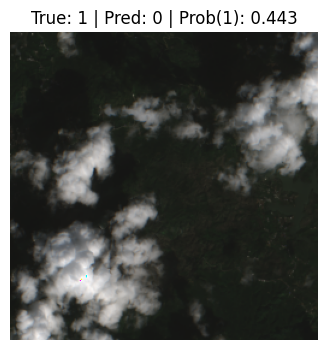

In [ ]:
show_prediction(model, test_ds, idx=0, device=device)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_prediction_with_ndvi(model, dataset, idx, device, threshold=0.2):
    model.eval()

    fname = dataset.file_names[idx]
    rgb_path = os.path.join(dataset.img_dir, fname)

    # Load original RGB
    rgb = Image.open(rgb_path).convert("RGB")

    # Load NDVI
    ndvi_fname = fname.replace("_img_", "_ndvi_")
    ndvi_path = os.path.join(dataset.label_dir, ndvi_fname)
    ndvi = Image.open(ndvi_path)
    ndvi_arr = np.array(ndvi)

    # Run model
    img_tensor, label = dataset[idx]
    img_batch = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        prob = model(img_batch).item()

    pred = 1 if prob > threshold else 0

    # Plot
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(rgb)
    plt.title(f"RGB\nTrue: {label.item()} | Pred: {pred} | Prob: {prob:.3f}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(ndvi_arr, cmap="viridis")
    plt.title("NDVI")
    plt.colorbar()
    plt.axis("off")

    plt.show()


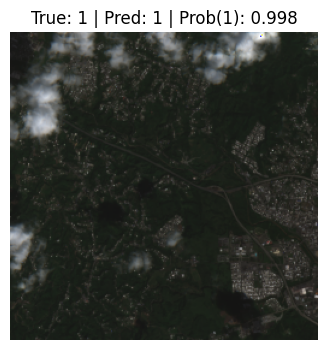

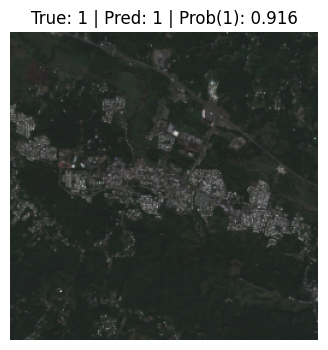

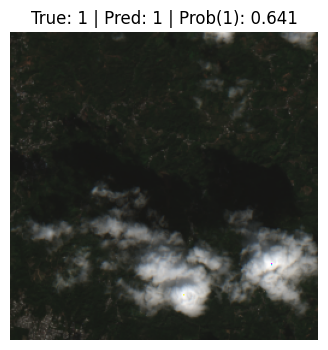

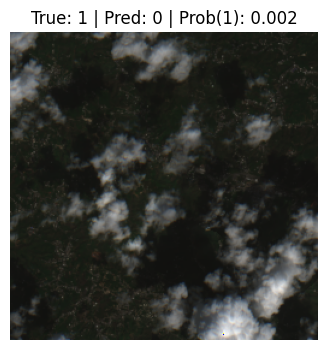

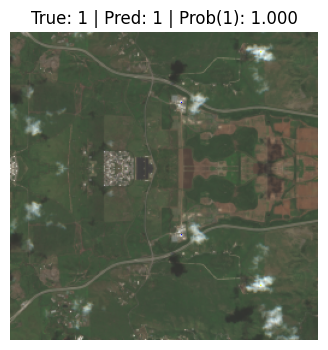

In [ ]:
import random
for _ in range(5):
    idx = random.randint(0, len(test_ds)-1)
    show_prediction(model, test_ds, idx, device)
